This notebook
1. reads in asset prices with relevant trading signals
2. uses financial evaluation function to produce financial results
3. creates suitable output tables for LaTeX

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

import sys
sys.path.append('../utils/evaluation')
from financial_evaluation import financial_evaluation

from mlxtend.evaluate import permutation_test

### Overall

In [2]:
competing_strategies = ["RSI_Signals", "BB_Signals", "BaH_Signals"]
cnn_versions = ["indiv", "univ"]
Names = ['GSPC', 'N225','IXIC', 'AAPL', 'SPY']

In [3]:
all_strats = ["indiv", "univ", "RSI", "BB", "BaH"]

# Test 1 (2006-2007)

### Main results

In [4]:
Results1 = pd.DataFrame(columns = ["Assets", "Cumr_indiv", "Cumr_univ", "Cumr_RSI", "Cumr_BB", "Cumr_BaH",
                                    "Annr_indiv", "Annr_univ", "Annr_RSI", "Annr_BB", "Annr_BaH",
                                    "Tr_indiv", "Tr_univ", "Tr_RSI", "Tr_BB", "Tr_BaH"
                                   ])
Results1['Assets'] = Names

### Appendix results

In [5]:
App_results1 = pd.DataFrame(columns = ["Assets", "TotalPL_indiv", "TotalPL_univ", "TotalPL_RSI", "TotalPL_BB", "TotalPL_BaH",
                                    "TotalPL_Tr_indiv", "TotalPL_Tr_univ", "TotalPL_Tr_RSI", "TotalPL_Tr_BB", "TotalPL_Tr_BaH"
                                   ])
App_results1['Assets'] = Names

## Capital evolution

In [6]:
Capitals = pd.DataFrame(columns = ["CNN_i", "CNN_u", "RSI", "BB", "BaH"])

### Competing Strategies

In [7]:
competing_path1 = "../data/competing-strategies-signals/test1/"
competing1 = []
competing_results1 = []
names = []

In [8]:
for name in os.listdir(competing_path1):
    #get data
    competing1.append(pd.read_csv(competing_path1 + name).dropna())
    #check data
    print(competing1[-1].head())
    
    #add Buy & Hold
    competing1[-1]['BaH_Signals'] = 'Hold'
    competing1[-1]['BaH_Signals'].iloc[0] = 'Buy'
    competing1[-1]['BaH_Signals'].iloc[-1] = 'Sell'
    
    #check
    print(competing1[-1].head())
    print(competing1[-1].tail())
    
    #get varname
    VarName = name[6:name.index('_com')]
    names.append(VarName)
    
    vars()["Capitals1_" + VarName] = Capitals.copy()
    
    for strat in competing_strategies:
        #get results for certain asset and strategy
        competing_results1.append(financial_evaluation(varname = VarName + '_' + strat,
                                                       prices = np.array(competing1[-1][VarName]), 
                                                       signals = np.array(competing1[-1][strat])))
        # Save to tables
        Results1['Cumr_' + strat[:-8]].loc[Results1['Assets'] == VarName] =competing_results1[-1]['cumulative_return']
        Results1['Annr_' + strat[:-8]].loc[Results1['Assets'] == VarName] =competing_results1[-1]['annualized_return']
        Results1['Tr_' + strat[:-8]].loc[Results1['Assets'] == VarName] =competing_results1[-1]['all_trades']
        
        App_results1['TotalPL_' + strat[:-8]].loc[App_results1['Assets'] == VarName] =competing_results1[-1]['total_profit_loss']
        App_results1['TotalPL_Tr_' + strat[:-8]].loc[App_results1['Assets'] == VarName] =competing_results1[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals1_" + VarName)[strat[:-8]] = competing_results1[-1]['capital']

   Unnamed: 0      AAPL RSI_Signals BB_Signals
0  2006-01-04  7.114065        Hold       Hold
1  2006-01-05  7.058076        Hold       Hold
2  2006-01-06  7.240269        Hold       Sell
3  2006-01-09  7.216549        Hold       Hold
4  2006-01-10  7.672980        Hold       Sell
   Unnamed: 0      AAPL RSI_Signals BB_Signals BaH_Signals
0  2006-01-04  7.114065        Hold       Hold         Buy
1  2006-01-05  7.058076        Hold       Hold        Hold
2  2006-01-06  7.240269        Hold       Sell        Hold
3  2006-01-09  7.216549        Hold       Hold        Hold
4  2006-01-10  7.672980        Hold       Sell        Hold
     Unnamed: 0       AAPL RSI_Signals BB_Signals BaH_Signals
514  2007-12-25  18.864561        Hold       Hold        Hold
515  2007-12-26  18.878799        Hold       Hold        Hold
516  2007-12-27  18.842733        Hold       Hold        Hold
517  2007-12-28  18.962296        Hold       Hold        Hold
518  2007-12-31  18.796236        Hold       Hold     

C:\Users\Corvinus\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
../utils/evaluation\financial_evaluation.py:277: RuntimeWarning: divide by zero encountered in double_scalars
  avg_trade_profit = total_profit / winners


### Model Results

In [9]:
cnns_path1 = "../results tables/Results/test1"
cnns1 = []
cnns_result1 = []

In [10]:
# check for data on relevant model variant
for variant in cnn_versions:
    cnns_path1_ = cnns_path1 + "/" + variant
    abbrev = variant[0]
    for VarName in os.listdir(cnns_path1_):
        
        #get data
        cnns1.append(pd.read_csv(cnns_path1_ + "/" + VarName + "/" + "PredForFinEval.csv").dropna())

        #check
        #print(cnns1[-1].head())

        # get financial results for each asset, each model variant

        cnns_result1.append(financial_evaluation(varname = VarName + '_' + variant,
                                                       prices = np.array(cnns1[-1][VarName]), 
                                                       signals = np.array(cnns1[-1]["Signals"]),
                                                       safety = True))
        # Save to tables
        Results1['Cumr_' + variant].loc[Results1['Assets'] == VarName] = cnns_result1[-1]['cumulative_return']
        Results1['Annr_' + variant].loc[Results1['Assets'] == VarName] = cnns_result1[-1]['annualized_return']
        Results1['Tr_' + variant].loc[Results1['Assets'] == VarName] = cnns_result1[-1]['all_trades']

        App_results1['TotalPL_' + variant].loc[App_results1['Assets'] == VarName] =cnns_result1[-1]['total_profit_loss']
        App_results1['TotalPL_Tr_' + variant].loc[App_results1['Assets'] == VarName] =cnns_result1[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals1_" + VarName)['CNN_' + abbrev] = cnns_result1[-1]['capital']

In [11]:
Results1

,Assets,Cumr_indiv,Cumr_univ,Cumr_RSI,Cumr_BB,Cumr_BaH,Annr_indiv,Annr_univ,Annr_RSI,Annr_BB,Annr_BaH,Tr_indiv,Tr_univ,Tr_RSI,Tr_BB,Tr_BaH
0,GSPC,0.145881,0.284784,0.127197,0.158637,0.151971,0.0705988,0.133757,0.0618179,0.0765525,0.0734455,52,89,7,12,2
1,N225,-0.00344719,0.101227,0.162062,0.134378,-0.0653725,-0.00172841,0.0494911,0.078146,0.065201,-0.0333016,44,94,9,11,2
2,IXIC,0.0143253,0.13427,0.100534,-0.0126179,0.170695,0.00715099,0.0651504,0.0491601,-0.00634115,0.0821511,37,92,7,7,2
3,AAPL,0.615457,0.390348,0.730272,0.831773,1.6403,0.271594,0.179504,0.316093,0.354219,0.626421,38,72,10,10,2
4,SPY,0.127985,0.249724,0.129077,0.0589208,0.190277,0.0621894,0.118151,0.0627045,0.0290955,0.0911814,44,94,7,7,2


In [12]:
App_results1

,Assets,TotalPL_indiv,TotalPL_univ,TotalPL_RSI,TotalPL_BB,TotalPL_BaH,TotalPL_Tr_indiv,TotalPL_Tr_univ,TotalPL_Tr_RSI,TotalPL_Tr_BB,TotalPL_Tr_BaH
0,GSPC,1458.81,2847.84,1271.97,1586.37,1519.71,28.0541,31.9982,181.71,132.197,759.856
1,N225,-34.4719,1012.27,1620.62,1343.78,-653.725,-0.783453,10.7688,180.069,122.161,-326.862
2,IXIC,143.253,1342.7,1005.34,-126.179,1706.95,3.87171,14.5946,143.62,-18.0256,853.477
3,AAPL,6154.57,3903.48,7302.72,8317.73,16403,161.962,54.2149,730.272,831.773,8201.51
4,SPY,1279.85,2497.24,1290.77,589.208,1902.77,29.0874,26.5664,184.395,84.1725,951.386


In [13]:
Results1.to_csv('../results tables/test1_main_financial_results.csv')
App_results1.to_csv('../results tables/test1_appendix_financial_results.csv')

## Permuation test (I)

In [14]:
PermutationTest1 = pd.DataFrame(columns = ["Strategy 1", "Strategy 2", "p-value (equal means)", "p-value (equal variances)"
                                           ])

In [15]:
for strat1 in cnn_versions:
    for strat2 in all_strats:
        if strat1 != strat2:
            pmean = permutation_test(Results1['Annr_'+strat1], Results1['Annr_' + strat2])
            pvar = permutation_test(Results1['Annr_' + strat1], Results1['Annr_' + strat2], 
                                                                       func = lambda x, y: np.abs(np.std(y) / np.std(x))-1)

            PermutationTest1 = PermutationTest1.append({'Strategy 1': strat1, 
                                                        'Strategy 2': strat2, 
                                                        'p-value (equal means)': pmean, 
                                                        'p-value (equal variances)': pvar}, ignore_index=True)

        
print(PermutationTest1)

  Strategy 1 Strategy 2  p-value (equal means)  p-value (equal variances)
0      indiv       univ               0.626984                   0.837302
1      indiv        RSI               0.515873                   0.460317
2      indiv         BB               0.658730                   0.376984
3      indiv        BaH               0.619048                   0.396825
4       univ      indiv               0.626984                   0.158730
5       univ        RSI               0.952381                   0.281746
6       univ         BB               0.960317                   0.154762
7       univ        BaH               0.904762                   0.198413


In [16]:
PermutationTest1.to_csv('../results tables/test1_permutationtest.csv')

## Capital evolution plots

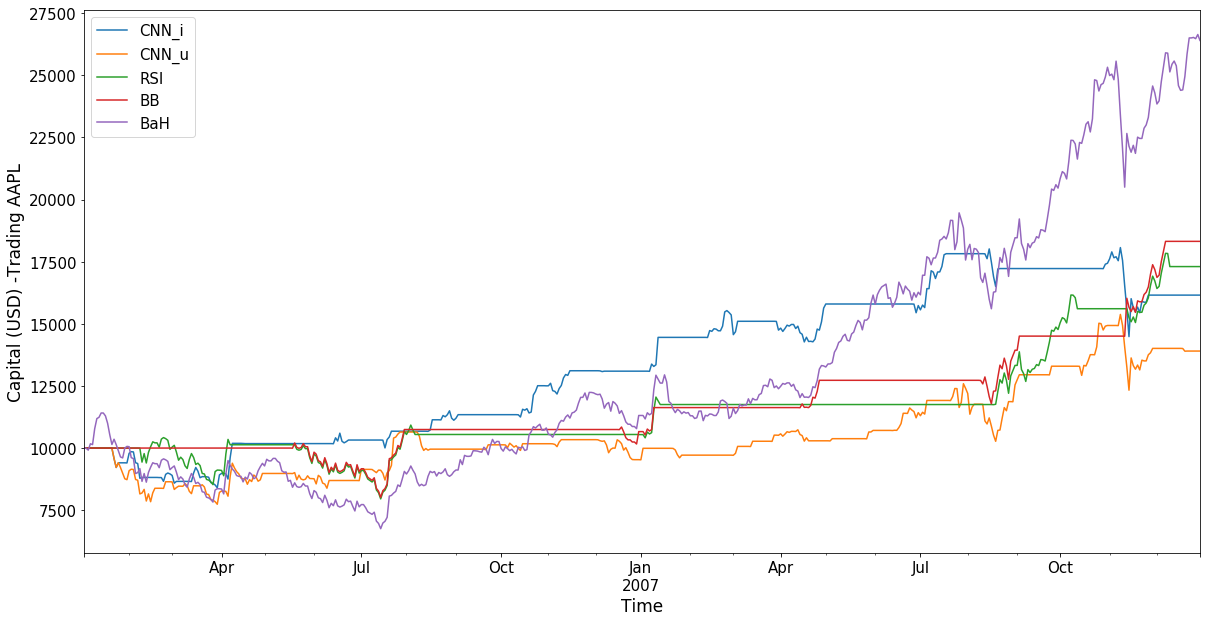

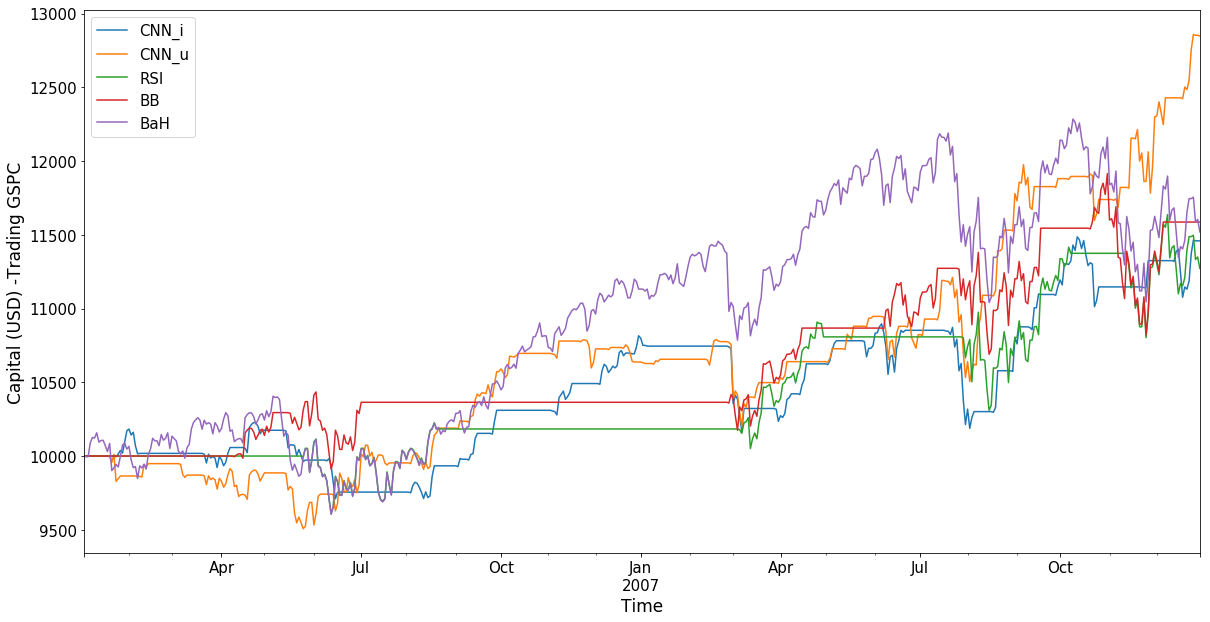

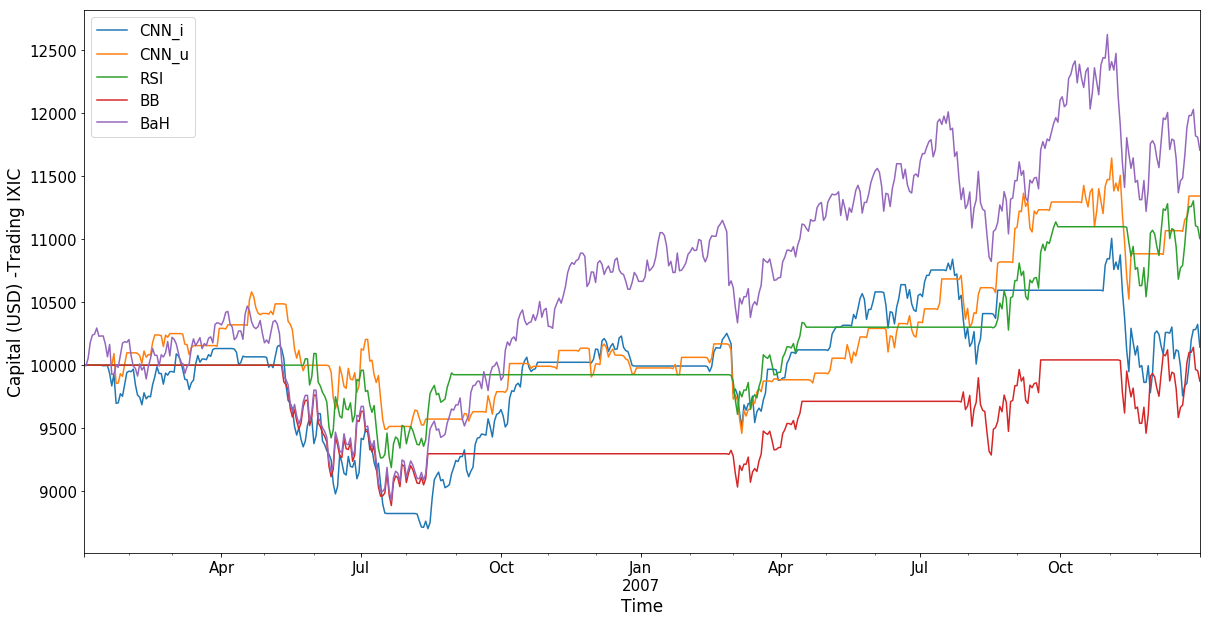

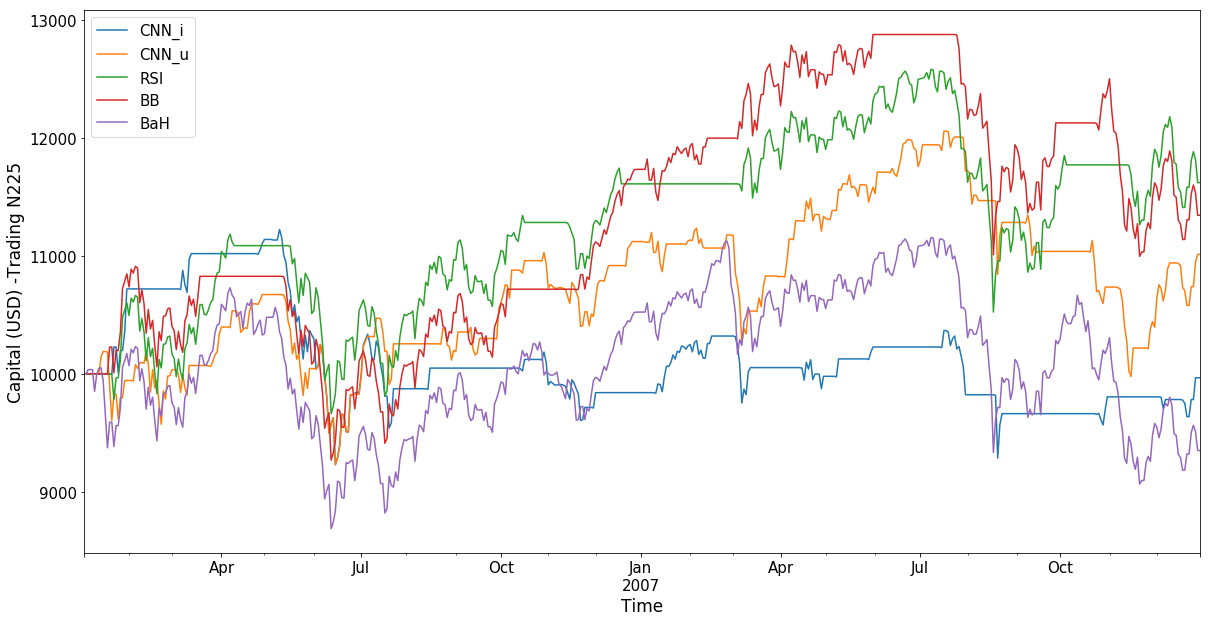

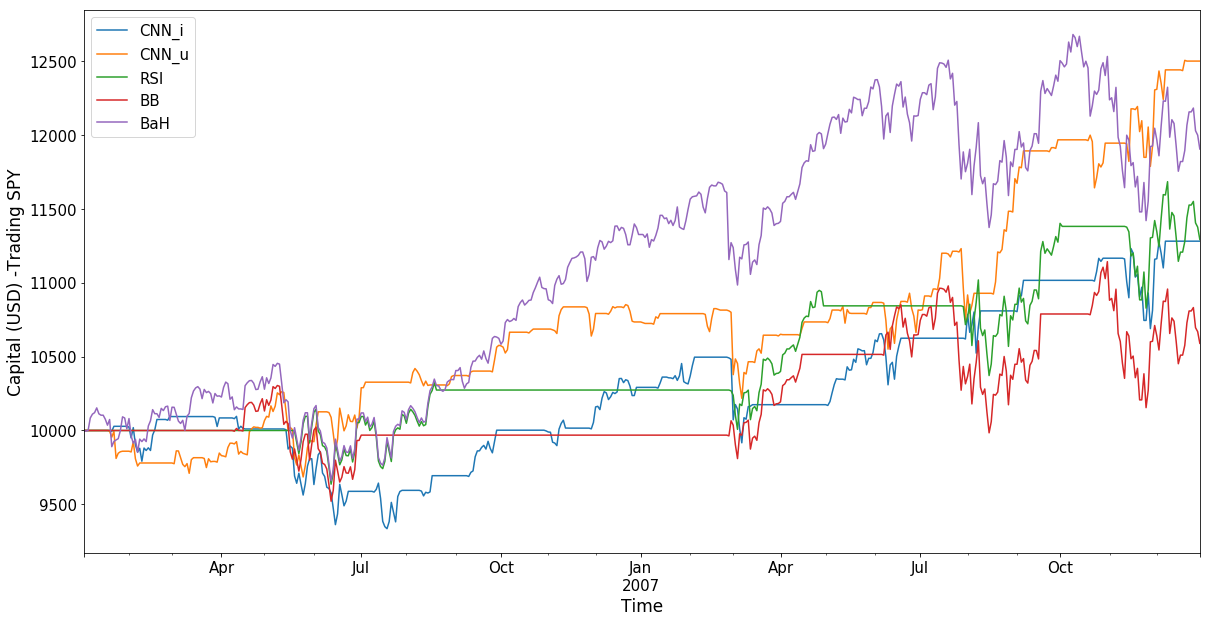

In [17]:
for name in names:
    
    #add date 
    eval("Capitals1_" + name)['Date'] = pd.bdate_range(start='1/3/2006', end='12/31/2007')
    eval("Capitals1_" + name).set_index('Date', inplace=True)
    
    plt.rc('font', family = 'sans-serif')
    eval("Capitals1_" + name).plot(figsize = (20,10), fontsize = 15)
                                   
    plt.ylabel("Capital (USD) -Trading " + name, fontsize = 17)
    plt.xlabel("Time", fontsize = 17)
    plt.legend(loc=2, prop={'size': 15})
    plt.savefig("../report/0304(0)_report/images/capitals/Capitals1_" + name +'.png')
    plt.show()

# Test 2 (2009-2010)

### Main results

In [18]:
Results2 = pd.DataFrame(columns = ["Assets", "Cumr_indiv", "Cumr_univ", "Cumr_RSI", "Cumr_BB", "Cumr_BaH",
                                    "Annr_indiv", "Annr_univ", "Annr_RSI", "Annr_BB", "Annr_BaH",
                                    "Tr_indiv", "Tr_univ", "Tr_RSI", "Tr_BB", "Tr_BaH"
                                   ])
Results2['Assets'] = Names

### Appendix results

In [19]:
App_results2 = pd.DataFrame(columns = ["Assets", "TotalPL_indiv", "TotalPL_univ", "TotalPL_RSI", "TotalPL_BB", "TotalPL_BaH",
                                    "TotalPL_Tr_indiv", "TotalPL_Tr_univ", "TotalPL_Tr_RSI", "TotalPL_Tr_BB", "TotalPL_Tr_BaH"
                                   ])
App_results2['Assets'] = Names

## Capital evolution

In [20]:
Capitals = pd.DataFrame(columns = ["CNN_i", "CNN_u", "RSI", "BB", "BaH"])

### Competing Strategies

In [21]:
competing_path2 = "../data/competing-strategies-signals/test2/"
competing2 = []
competing_results2 = []
names = []

In [22]:
for name in os.listdir(competing_path2):
    #get data
    competing2.append(pd.read_csv(competing_path2 + name).dropna())
    #check data
    print(competing2[-1].head())
    
    #add Buy & Hold
    competing2[-1]['BaH_Signals'] = 'Hold'
    competing2[-1]['BaH_Signals'].iloc[0] = 'Buy'
    competing2[-1]['BaH_Signals'].iloc[-1] = 'Sell'
    
    #check
    print(competing2[-1].head())
    print(competing2[-1].tail())
    
    #get varname
    VarName = name[6:name.index('_com')]
    names.append(VarName)
    
    vars()["Capitals2_" + VarName] = Capitals.copy()
    
    for strat in competing_strategies:
        #get results for certain asset and strategy
        competing_results2.append(financial_evaluation(varname = VarName + '_' + strat,
                                                       prices = np.array(competing2[-1][VarName]), 
                                                       signals = np.array(competing2[-1][strat])))
        # Save to tables
        Results2['Cumr_' + strat[:-8]].loc[Results2['Assets'] == VarName] =competing_results2[-1]['cumulative_return']
        Results2['Annr_' + strat[:-8]].loc[Results2['Assets'] == VarName] =competing_results2[-1]['annualized_return']
        Results2['Tr_' + strat[:-8]].loc[Results2['Assets'] == VarName] =competing_results2[-1]['all_trades']
        
        App_results2['TotalPL_' + strat[:-8]].loc[App_results2['Assets'] == VarName] =competing_results2[-1]['total_profit_loss']
        App_results2['TotalPL_Tr_' + strat[:-8]].loc[App_results2['Assets'] == VarName] =competing_results2[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals2_" + VarName)[strat[:-8]] = competing_results2[-1]['capital']

   Unnamed: 0      AAPL RSI_Signals BB_Signals
0  2009-01-05  8.974896        Hold       Hold
1  2009-01-06  8.826868        Hold       Hold
2  2009-01-07  8.636136        Hold       Hold
3  2009-01-08  8.796504        Hold       Hold
4  2009-01-09  8.595330        Hold       Hold
   Unnamed: 0      AAPL RSI_Signals BB_Signals BaH_Signals
0  2009-01-05  8.974896        Hold       Hold         Buy
1  2009-01-06  8.826868        Hold       Hold        Hold
2  2009-01-07  8.636136        Hold       Hold        Hold
3  2009-01-08  8.796504        Hold       Hold        Hold
4  2009-01-09  8.595330        Hold       Hold        Hold
     Unnamed: 0       AAPL RSI_Signals BB_Signals BaH_Signals
515  2010-12-27  30.809586        Hold       Hold        Hold
516  2010-12-28  30.884562        Hold       Hold        Hold
517  2010-12-29  30.867464        Hold       Hold        Hold
518  2010-12-30  30.712788        Hold       Hold        Hold
519  2010-12-31  30.608423        Hold       Hold     

### Model Results

In [23]:
cnns_path2 = "../results tables/Results/test2"
cnns2 = []
cnns_result2 = []

In [24]:
# check for data on relevant model variant
for variant in cnn_versions:
    cnns_path2_ = cnns_path2 + "/" + variant
    abbrev = variant[0]
    for VarName in os.listdir(cnns_path2_):
        
        #get data
        cnns2.append(pd.read_csv(cnns_path2_ + "/" + VarName + "/" + "PredForFinEval.csv").dropna())

        #check
        #print(cnns2[-1].head())

        # get financial results for each asset, each model variant

        cnns_result2.append(financial_evaluation(varname = VarName + '_' + variant,
                                                       prices = np.array(cnns2[-1][VarName]), 
                                                       signals = np.array(cnns2[-1]["Signals"]),
                                                       safety = True))
        # Save to tables
        Results2['Cumr_' + variant].loc[Results2['Assets'] == VarName] =cnns_result2[-1]['cumulative_return']
        Results2['Annr_' + variant].loc[Results2['Assets'] == VarName] =cnns_result2[-1]['annualized_return']
        Results2['Tr_' + variant].loc[Results2['Assets'] == VarName] =cnns_result2[-1]['all_trades']

        App_results2['TotalPL_' + variant].loc[App_results2['Assets'] == VarName] =cnns_result2[-1]['total_profit_loss']
        App_results2['TotalPL_Tr_' + variant].loc[App_results2['Assets'] == VarName] =cnns_result2[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals2_" + VarName)['CNN_' + abbrev] = cnns_result2[-1]['capital']

In [25]:
Results2

,Assets,Cumr_indiv,Cumr_univ,Cumr_RSI,Cumr_BB,Cumr_BaH,Annr_indiv,Annr_univ,Annr_RSI,Annr_BB,Annr_BaH,Tr_indiv,Tr_univ,Tr_RSI,Tr_BB,Tr_BaH
0,GSPC,0.245756,0.365425,0.122882,0.296574,0.354841,0.116134,0.168514,0.0596612,0.138672,0.163976,32,78,6,6,2
1,N225,-0.135709,-0.0453963,0.0968867,0.281691,0.130062,-0.0703274,-0.0229618,0.0473236,0.132118,0.0630436,38,69,8,12,2
2,IXIC,0.3877,0.282676,0.317421,0.712115,0.628182,0.178007,0.132553,0.14779,0.308478,0.276002,45,84,6,12,2
3,AAPL,1.60213,2.05007,0.515813,0.636746,2.40824,0.61311,0.746446,0.231183,0.279354,0.846143,51,80,6,8,2
4,SPY,0.109649,0.490836,0.146519,0.157547,0.411683,0.0533988,0.220998,0.0707561,0.0758937,0.188143,32,72,6,6,2


In [26]:
App_results2

,Assets,TotalPL_indiv,TotalPL_univ,TotalPL_RSI,TotalPL_BB,TotalPL_BaH,TotalPL_Tr_indiv,TotalPL_Tr_univ,TotalPL_Tr_RSI,TotalPL_Tr_BB,TotalPL_Tr_BaH
0,GSPC,2457.56,3654.25,1228.82,2965.74,3548.41,76.7988,46.8493,204.803,494.29,1774.21
1,N225,-1357.09,-453.963,968.867,2816.91,1300.62,-35.7129,-6.57917,121.108,234.742,650.309
2,IXIC,3877,2826.76,3174.21,7121.15,6281.82,86.1556,33.6519,529.035,593.429,3140.91
3,AAPL,16021.3,20500.7,5158.13,6367.46,24082.4,314.142,256.259,859.688,795.933,12041.2
4,SPY,1096.49,4908.36,1465.19,1575.47,4116.83,34.2653,68.1716,244.198,262.579,2058.41


In [27]:
Results2.to_csv('../results tables/test2_main_financial_results.csv')
App_results2.to_csv('../results tables/test2_appendix_financial_results.csv')

## Permuation test (II)

In [28]:
PermutationTest2 = pd.DataFrame(columns = ["Strategy 1", "Strategy 2", "p-value (equal means)", "p-value (equal variances)"
                                           ])

In [29]:
for strat1 in cnn_versions:
    for strat2 in all_strats:
        if strat1 != strat2:
            pmean = permutation_test(Results2['Annr_'+strat1], Results2['Annr_' + strat2])
            pvar = permutation_test(Results2['Annr_' + strat1], Results2['Annr_' + strat2], 
                                                                       func = lambda x, y: np.abs(np.std(y) / np.std(x))-1)

            PermutationTest2 = PermutationTest2.append({'Strategy 1': strat1, 
                                                        'Strategy 2': strat2, 
                                                        'p-value (equal means)': pmean, 
                                                        'p-value (equal variances)': pvar}, ignore_index=True)


print(PermutationTest2)

  Strategy 1 Strategy 2  p-value (equal means)  p-value (equal variances)
0      indiv       univ               0.595238                   0.428571
1      indiv        RSI               0.738095                   0.813492
2      indiv         BB               0.952381                   0.849206
3      indiv        BaH               0.484127                   0.472222
4       univ      indiv               0.595238                   0.567460
5       univ        RSI               0.404762                   0.789683
6       univ         BB               0.801587                   0.750000
7       univ        BaH               0.642857                   0.428571


In [30]:
PermutationTest2.to_csv('../results tables/test2_permutationtest.csv')

## Capital evolution plots

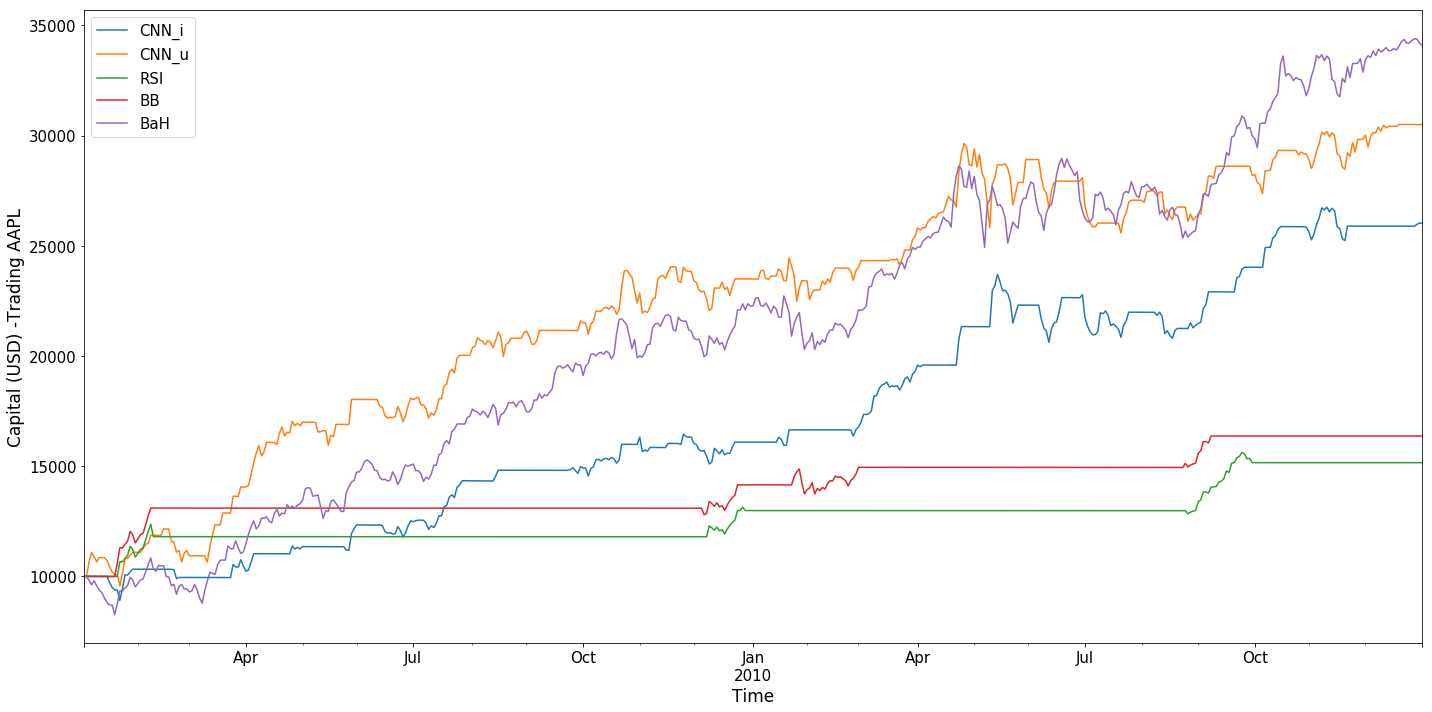

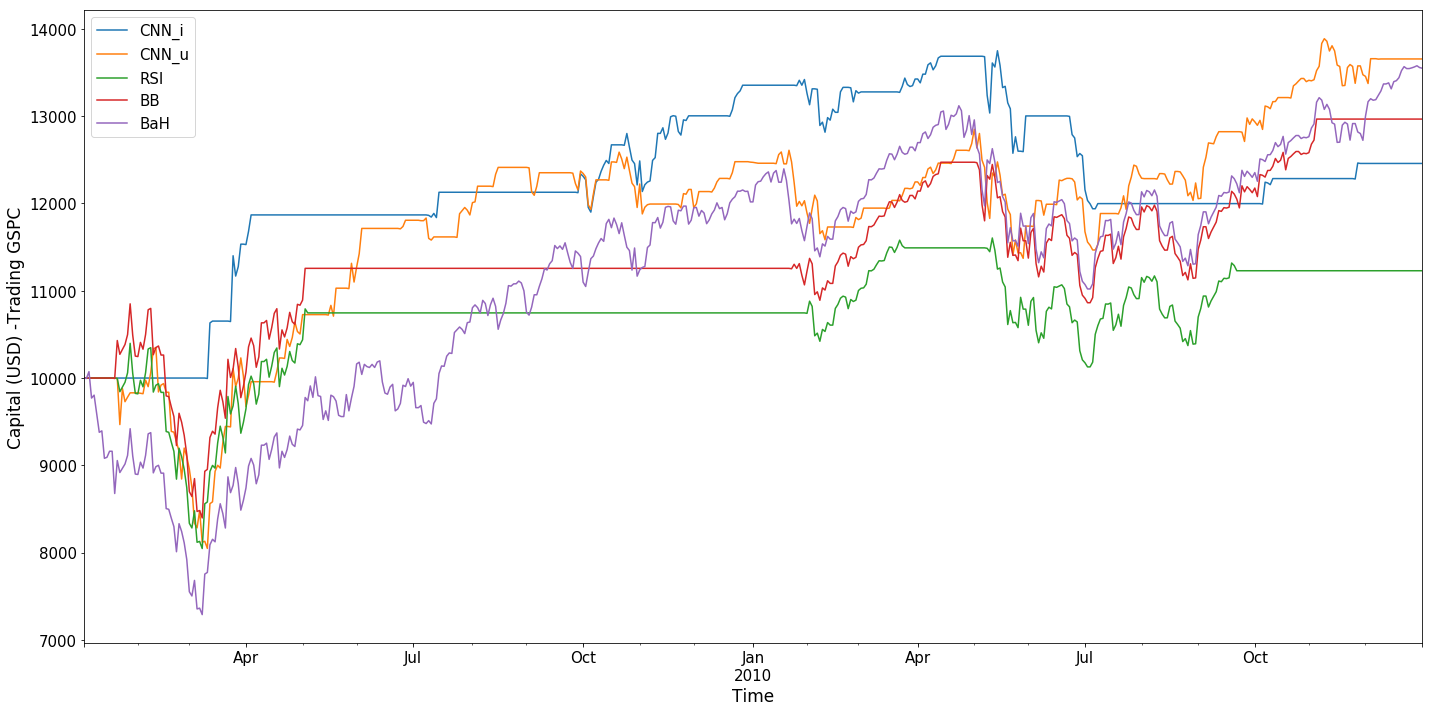

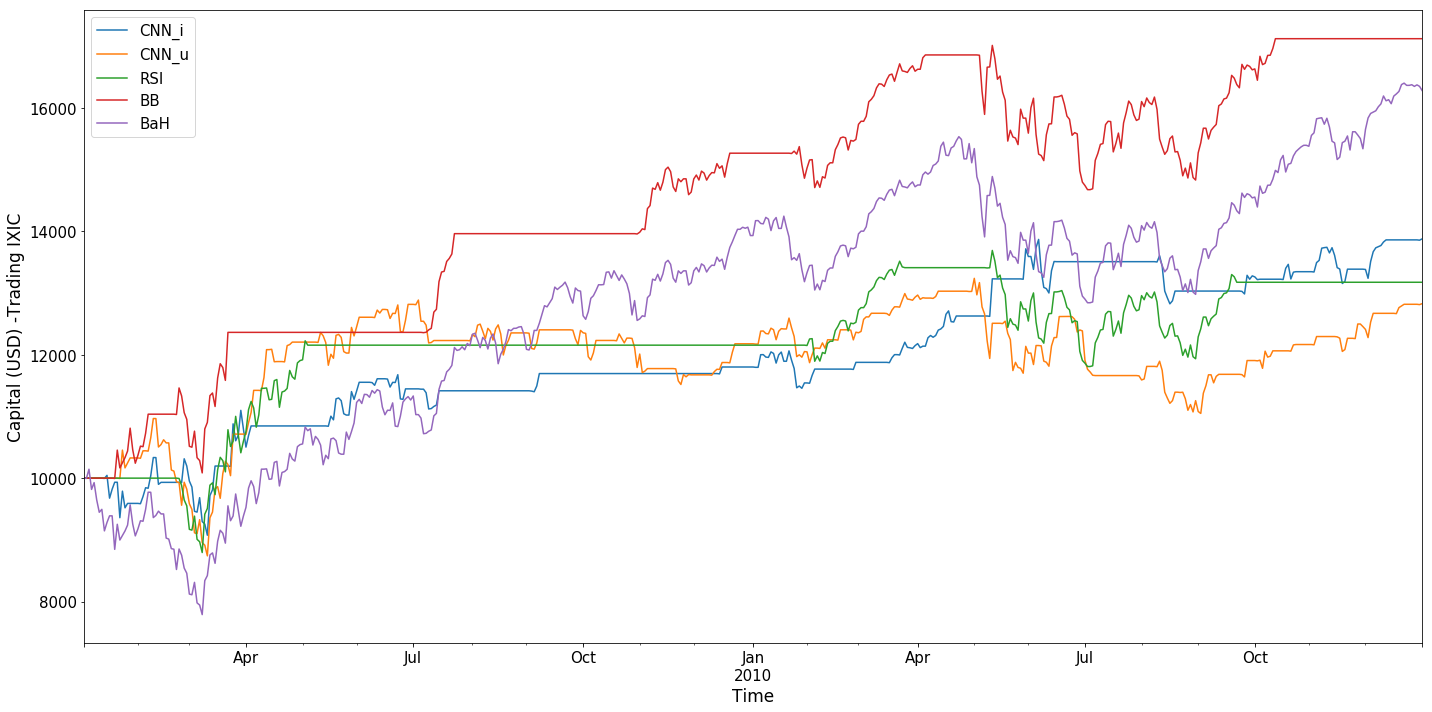

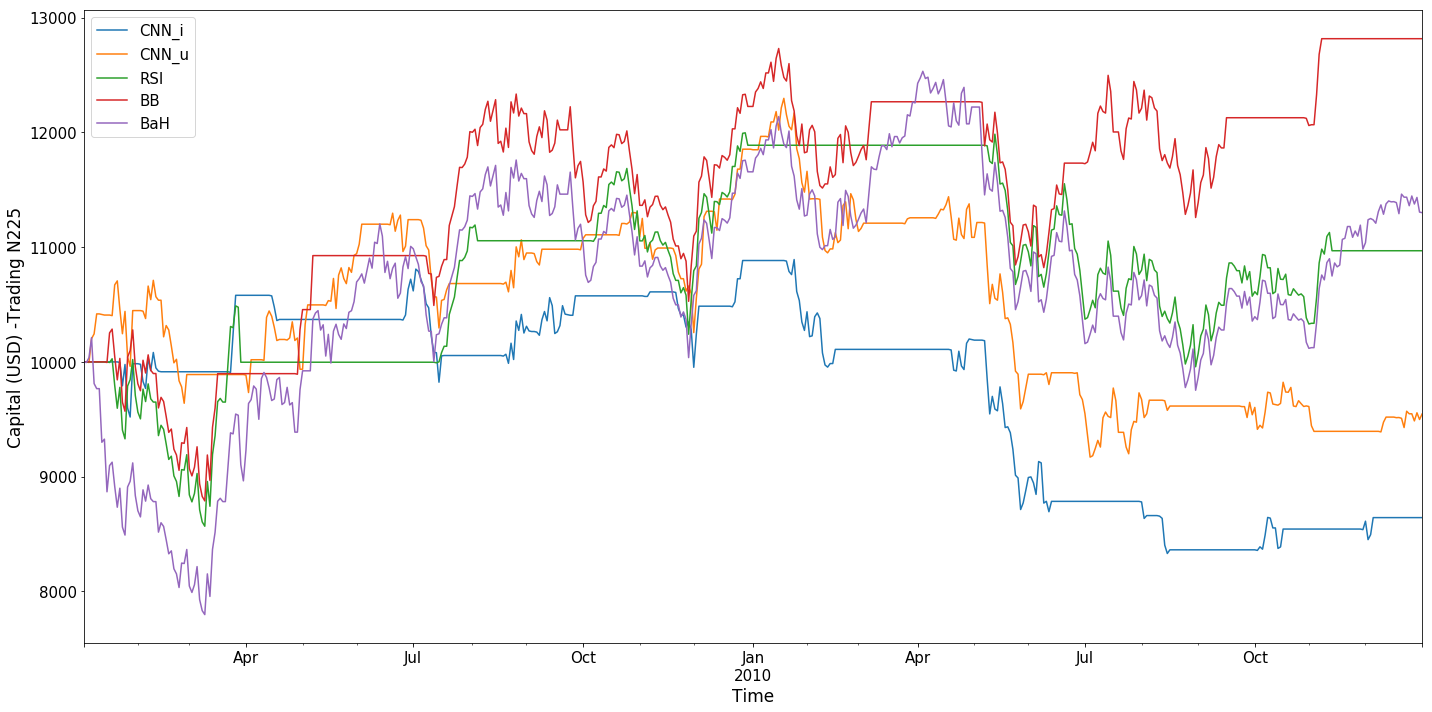

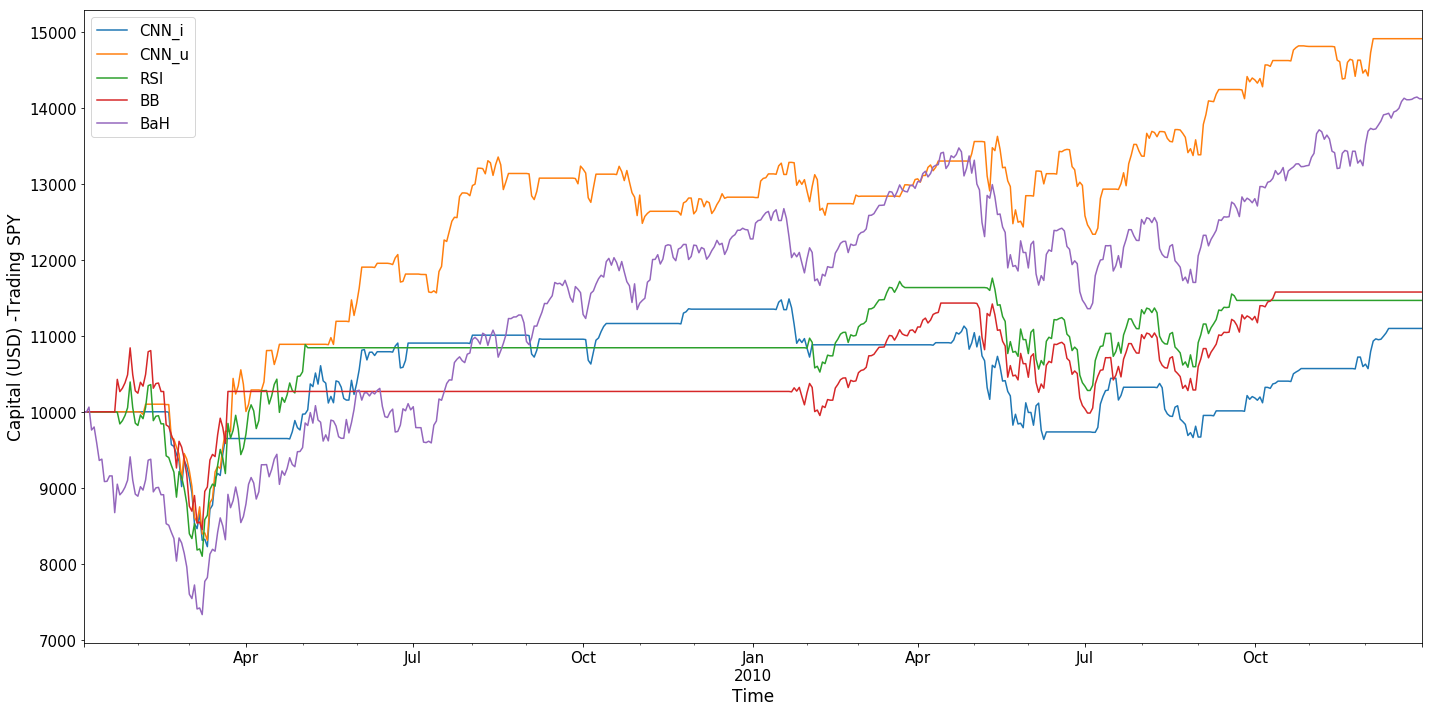

In [31]:
for name in names:
    
    #add date 
    eval("Capitals2_" + name)['Date'] = pd.bdate_range(start='1/2/2009', end='12/31/2010')
    eval("Capitals2_" + name).set_index('Date', inplace=True)
    
    plt.rc('font', family = 'sans-serif')
    eval("Capitals2_" + name).plot(figsize = (20,10), fontsize = 15)
                                   
    plt.ylabel("Capital (USD) -Trading " + name, fontsize = 17)
    plt.xlabel("Time", fontsize = 17)
    plt.legend(loc=2, prop={'size': 15})
    plt.tight_layout()
    plt.savefig("../report/0304(0)_report/images/capitals/Capitals2_" + name +'.png')
    plt.show()

# Test 3 (2017-2018/19)

### Main results

In [32]:
Results3 = pd.DataFrame(columns = ["Assets", "Cumr_indiv", "Cumr_univ", "Cumr_RSI", "Cumr_BB", "Cumr_BaH",
                                    "Annr_indiv", "Annr_univ", "Annr_RSI", "Annr_BB", "Annr_BaH",
                                    "Tr_indiv", "Tr_univ", "Tr_RSI", "Tr_BB", "Tr_BaH"
                                   ])
Results3['Assets'] = Names

### Appendix results

In [33]:
App_results3 = pd.DataFrame(columns = ["Assets", "TotalPL_indiv", "TotalPL_univ", "TotalPL_RSI", "TotalPL_BB", "TotalPL_BaH",
                                    "TotalPL_Tr_indiv", "TotalPL_Tr_univ", "TotalPL_Tr_RSI", "TotalPL_Tr_BB", "TotalPL_Tr_BaH"
                                   ])
App_results3['Assets'] = Names

### Competing Strategies

In [34]:
competing_path3 = "../data/competing-strategies-signals/test3/"
competing3 = []
competing_results3 = []
names = []

In [35]:
for name in os.listdir(competing_path3):
    #get data
    competing3.append(pd.read_csv(competing_path3 + name).dropna())
    #check data
    print(competing3[-1].head())
    
    #add Buy & Hold
    competing3[-1]['BaH_Signals'] = 'Hold'
    competing3[-1]['BaH_Signals'].iloc[0] = 'Buy'
    competing3[-1]['BaH_Signals'].iloc[-1] = 'Sell'
    
    #check
    print(competing3[-1].head())
    print(competing3[-1].tail())
    
    #get varname
    VarName = name[6:name.index('_com')]
    names.append(VarName)
    
    vars()["Capitals3_" + VarName] = Capitals.copy()
    
    for strat in competing_strategies:
        #get results for certain asset and strategy
        competing_results3.append(financial_evaluation(varname = VarName + '_' + strat,
                                                       prices = np.array(competing3[-1][VarName]), 
                                                       signals = np.array(competing3[-1][strat])
                                                      ))
        # Save to tables
        Results3['Cumr_' + strat[:-8]].loc[Results3['Assets'] == VarName] =competing_results3[-1]['cumulative_return']
        Results3['Annr_' + strat[:-8]].loc[Results3['Assets'] == VarName] =competing_results3[-1]['annualized_return']
        Results3['Tr_' + strat[:-8]].loc[Results3['Assets'] == VarName] =competing_results3[-1]['all_trades']
        
        App_results3['TotalPL_' + strat[:-8]].loc[App_results3['Assets'] == VarName] =competing_results3[-1]['total_profit_loss']
        App_results3['TotalPL_Tr_' + strat[:-8]].loc[App_results3['Assets'] == VarName] =competing_results3[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals3_" + VarName)[strat[:-8]] = competing_results3[-1]['capital']

   Unnamed: 0        AAPL RSI_Signals BB_Signals
0  2017-06-05  149.301117        Hold       Hold
1  2017-06-06  149.805511        Hold       Hold
2  2017-06-07  150.697861        Hold       Hold
3  2017-06-08  150.329269        Hold       Hold
4  2017-06-09  144.500000        Hold        Buy
   Unnamed: 0        AAPL RSI_Signals BB_Signals BaH_Signals
0  2017-06-05  149.301117        Hold       Hold         Buy
1  2017-06-06  149.805511        Hold       Hold        Hold
2  2017-06-07  150.697861        Hold       Hold        Hold
3  2017-06-08  150.329269        Hold       Hold        Hold
4  2017-06-09  144.500000        Hold        Buy        Hold
     Unnamed: 0        AAPL RSI_Signals BB_Signals BaH_Signals
520  2019-06-03  173.300003        Hold       Hold        Hold
521  2019-06-04  179.639999         Buy       Hold        Hold
522  2019-06-05  182.539993        Hold       Hold        Hold
523  2019-06-06  185.220001        Hold       Hold        Hold
524  2019-06-07  190.1499

### Model Results

In [36]:
cnns_path3 = "../results tables/Results/test3"
cnns3 = []
cnns_result3 = []

In [37]:
# check for data on relevant model variant
for variant in cnn_versions:
    cnns_path3_ = cnns_path3 + "/" + variant
    abbrev = variant[0]
    for VarName in os.listdir(cnns_path3_):
        
        #get data
        cnns3.append(pd.read_csv(cnns_path3_ + "/" + VarName + "/" + "PredForFinEval.csv").dropna())

        #check
        #print(cnns3[-1].head())

        # get financial results for each asset, each model variant

        cnns_result3.append(financial_evaluation(varname = VarName + '_' + variant,
                                                       prices = np.array(cnns3[-1][VarName]), 
                                                       signals = np.array(cnns3[-1]["Signals"]),
                                                       safety = True))
        # Save to tables
        Results3['Cumr_' + variant].loc[Results3['Assets'] == VarName] =cnns_result3[-1]['cumulative_return']
        Results3['Annr_' + variant].loc[Results3['Assets'] == VarName] =cnns_result3[-1]['annualized_return']
        Results3['Tr_' + variant].loc[Results3['Assets'] == VarName] =cnns_result3[-1]['all_trades']

        App_results3['TotalPL_' + variant].loc[App_results3['Assets'] == VarName] =cnns_result3[-1]['total_profit_loss']
        App_results3['TotalPL_Tr_' + variant].loc[App_results3['Assets'] == VarName] =cnns_result3[-1]['avg_profit_loss_trade']
        
        # Save Capitals for figures
        eval("Capitals3_" + VarName)['CNN_' + abbrev] = cnns_result3[-1]['capital']

In [38]:
Results3

,Assets,Cumr_indiv,Cumr_univ,Cumr_RSI,Cumr_BB,Cumr_BaH,Annr_indiv,Annr_univ,Annr_RSI,Annr_BB,Annr_BaH,Tr_indiv,Tr_univ,Tr_RSI,Tr_BB,Tr_BaH
0,GSPC,0.11043,0.0274935,-0.0242136,0.224313,0.178394,0.0532438,0.0135226,-0.0120657,0.105421,0.0846903,40,120,5,13,2
1,N225,0.187608,0.230617,0.100248,0.00795432,0.0343745,0.0888824,0.108236,0.0484499,0.0039314,0.0168784,51,111,9,11,2
2,IXIC,0.0346095,0.113054,0.108536,0.218864,0.228633,0.0169928,0.0544757,0.0523539,0.102982,0.107351,56,112,7,11,2
3,AAPL,0.150727,0.190476,0.403051,-0.0252192,0.272464,0.0720026,0.090184,0.182596,-0.01257,0.126742,47,114,11,11,2
4,SPY,0.0855282,0.118922,-0.0097977,0.237407,0.223645,0.0414798,0.0572255,-0.00486425,0.11126,0.105122,49,116,5,13,2


In [39]:
App_results3

,Assets,TotalPL_indiv,TotalPL_univ,TotalPL_RSI,TotalPL_BB,TotalPL_BaH,TotalPL_Tr_indiv,TotalPL_Tr_univ,TotalPL_Tr_RSI,TotalPL_Tr_BB,TotalPL_Tr_BaH
0,GSPC,1104.3,274.935,-242.136,2243.13,1783.94,27.6074,2.29113,-48.4272,172.548,891.969
1,N225,1876.08,2306.17,1002.48,79.5432,343.745,36.7859,20.7763,111.386,7.2312,171.873
2,IXIC,346.095,1130.54,1085.36,2188.64,2286.33,6.18026,10.0941,155.051,198.967,1143.17
3,AAPL,1507.27,1904.76,4030.51,-252.192,2724.64,32.0696,16.7084,366.41,-22.9265,1362.32
4,SPY,855.282,1189.22,-97.977,2374.07,2236.45,17.4547,10.2519,-19.5954,182.621,1118.22


In [40]:
Results3.to_csv('../results tables/test3_main_financial_results.csv')
App_results3.to_csv('../results tables/test3_appendix_financial_results.csv')

## Permuation test (III)

In [41]:
PermutationTest3 = pd.DataFrame(columns = ["Strategy 1", "Strategy 2", "p-value (equal means)", "p-value (equal variances)"
                                           ])

In [42]:
for strat1 in cnn_versions:
    for strat2 in all_strats:
        if strat1 != strat2:
            pmean = permutation_test(Results3['Annr_'+strat1], Results3['Annr_' + strat2])
            pvar = permutation_test(Results3['Annr_' + strat1], Results3['Annr_' + strat2], 
                                                                       func = lambda x, y: np.abs(np.std(y) / np.std(x))-1)

            PermutationTest3 = PermutationTest3.append({'Strategy 1': strat1, 
                                                        'Strategy 2': strat2, 
                                                        'p-value (equal means)': pmean, 
                                                        'p-value (equal variances)': pvar}, ignore_index=True)


print(PermutationTest3)

  Strategy 1 Strategy 2  p-value (equal means)  p-value (equal variances)
0      indiv       univ               0.611111                   0.246032
1      indiv        RSI               0.968254                   0.083333
2      indiv         BB               0.793651                   0.007937
3      indiv        BaH               0.182540                   0.111111
  Strategy 1 Strategy 2  p-value (equal means)  p-value (equal variances)
0      indiv       univ               0.611111                   0.246032
1      indiv        RSI               0.968254                   0.083333
2      indiv         BB               0.793651                   0.007937
3      indiv        BaH               0.182540                   0.111111
4       univ      indiv               0.611111                   0.750000
5       univ        RSI               0.793651                   0.115079
6       univ         BB               0.920635                   0.091270
7       univ        BaH               

In [43]:
PermutationTest3.to_csv('../results tables/test3_permutationtest.csv')

## Capital evolution plots

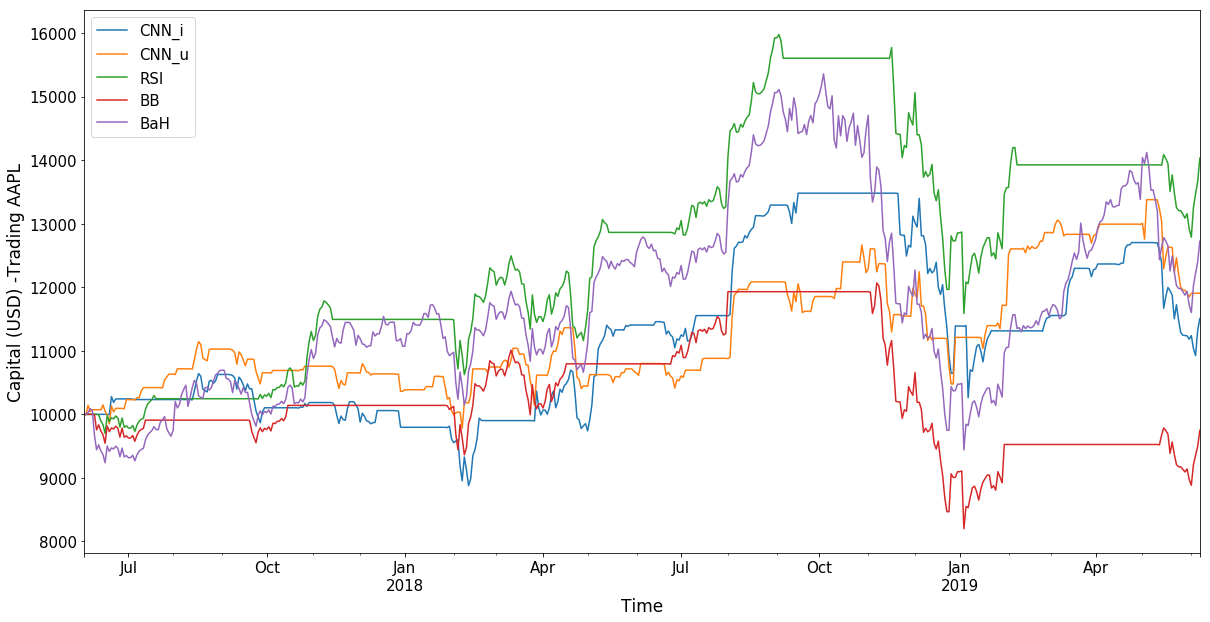

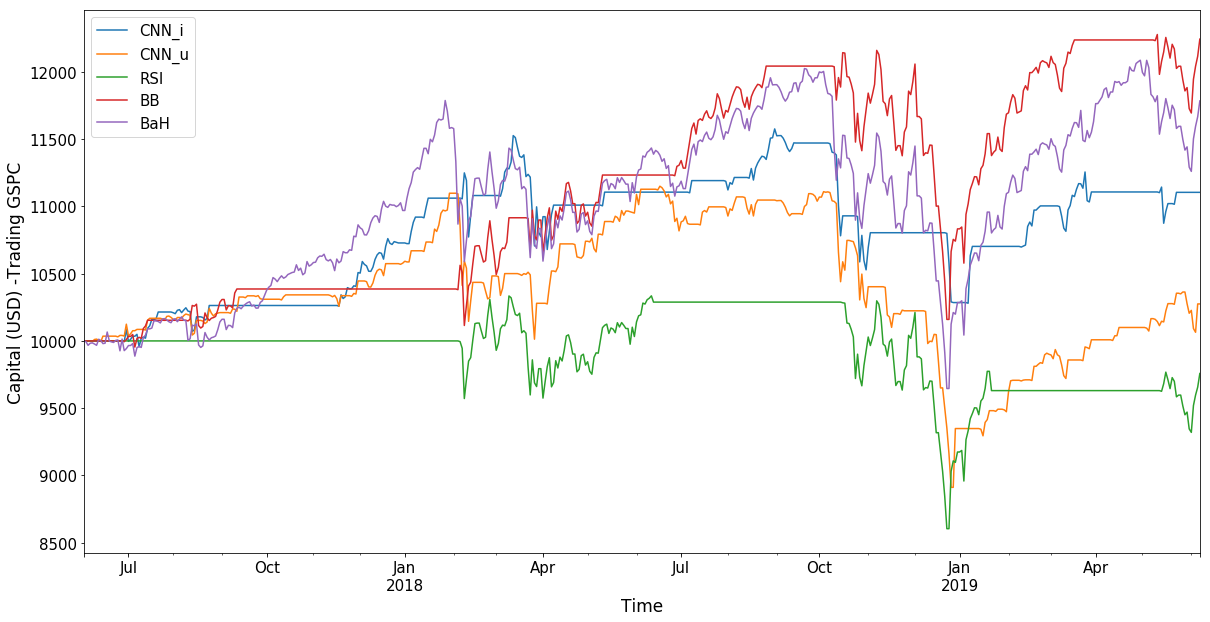

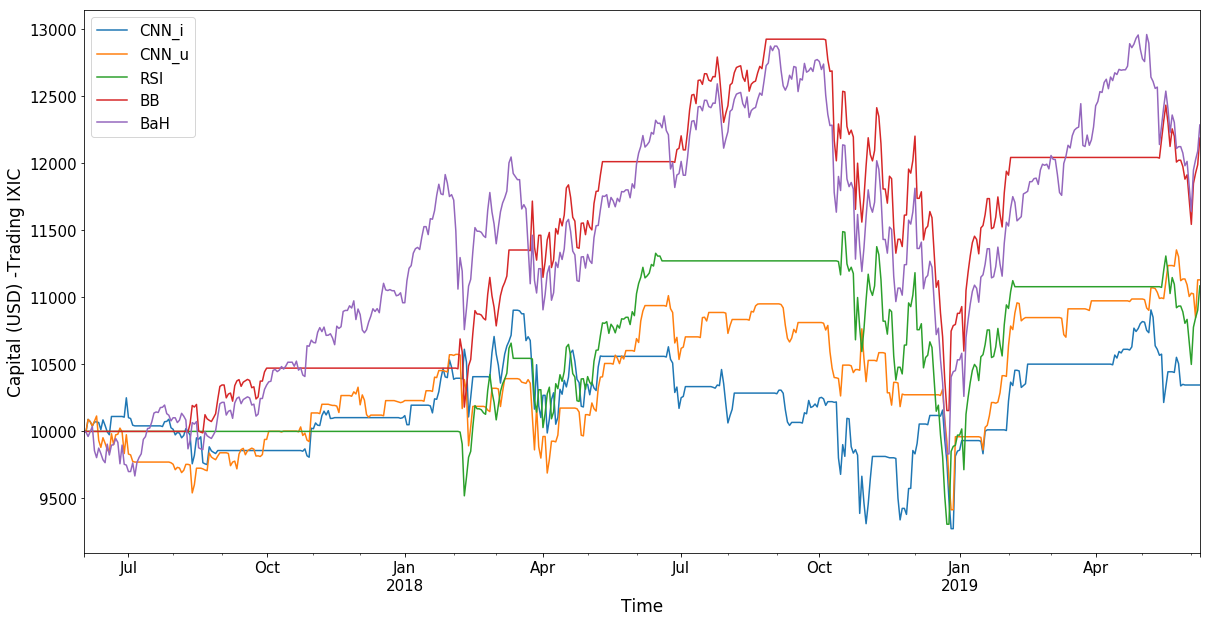

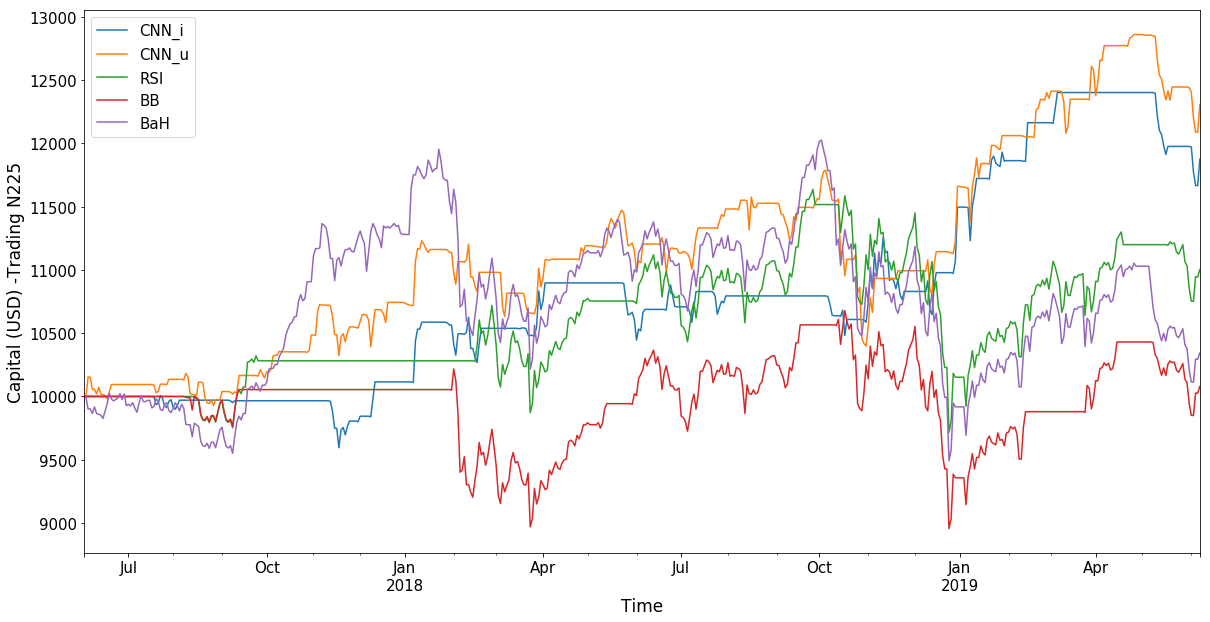

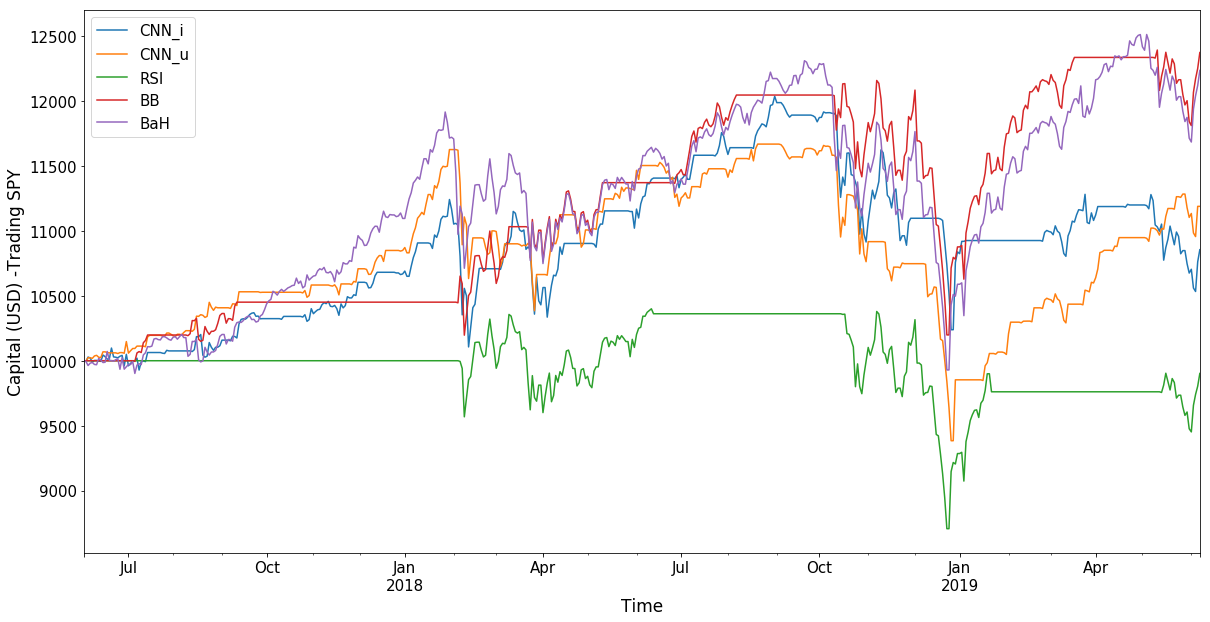

In [44]:
for name in names:
    
    #add date 
    eval("Capitals3_" + name)['Date'] = pd.bdate_range(start='6/2/2017', end='6/7/2019')
    eval("Capitals3_" + name).set_index('Date', inplace=True)
    
    plt.rc('font', family = 'sans-serif')
    eval("Capitals3_" + name).plot(figsize = (20,10), fontsize = 15)
                                   
    plt.ylabel("Capital (USD) -Trading " + name, fontsize = 17)
    plt.xlabel("Time", fontsize = 17)
    plt.legend(loc=2, prop={'size': 15})
    plt.savefig("../report/0304(0)_report/images/capitals/Capitals3_" + name +'.png')
    plt.show()